Example from scikit downscale

In [1]:
# modules
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

time_slice = slice('1990-01-01', '1990-12-31')

from sklearn.model_selection import train_test_split
from utils import get_sample_data

In [2]:
# function to plot

In [3]:
# utilities for plotting cdfs
def plot_cdf(ax=None, **kwargs):
    if ax:
        plt.sca(ax)
    else:
        ax = plt.gca()

    for label, X in kwargs.items():
        vals = np.sort(X, axis=0)
        pp = scipy.stats.mstats.plotting_positions(vals)
        ax.plot(pp, vals, label=label)
    ax.legend()
    return ax


def plot_cdf_by_month(ax=None, **kwargs):
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(12, 8))

    for label, X in kwargs.items():
        for month, ax in zip(range(1, 13), axes.flat):

            vals = np.sort(X[X.index.month == month], axis=0)
            pp = scipy.stats.mstats.plotting_positions(vals)
            ax.plot(pp, vals, label=label)
            ax.set_title(month)
    ax.legend()
    return ax

https://github.com/pangeo-data/scikit-downscale/blob/main/examples/2020ECAHM-scikit-downscale.ipynb

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
import scipy
import xarray as xr
import os
import os.path

import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_23584\1814528662.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_23584\1814528662.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing st

training               targets          
                 tmax           pcp    tmax       pcp
time                                                 
1950-01-01        NaN           NaN   -0.22  5.608394
1950-01-02        NaN           NaN   -4.54  2.919726
1950-01-03        NaN           NaN   -7.87  3.066762
1950-01-04        NaN           NaN   -5.08  4.684164
1950-01-05        NaN           NaN   -0.79  4.295568
...               ...           ...     ...       ...
2015-11-26   7.657013  0.000000e+00     NaN       NaN
2015-11-27   7.687256  0.000000e+00     NaN       NaN
2015-11-28  10.480835  0.000000e+00     NaN       NaN
2015-11-29  11.728516  0.000000e+00     NaN       NaN
2015-11-30  10.285431  3.152419e-13     NaN       NaN

[24075 rows x 4 columns]

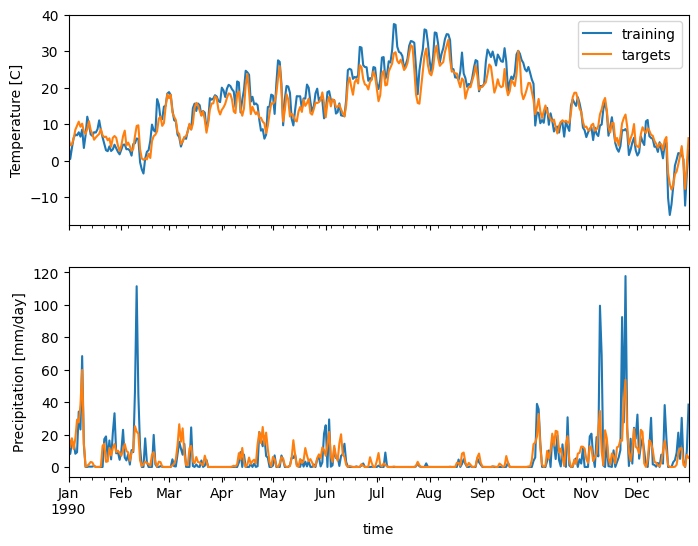

In [5]:
# load sample data
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
# extract 1 point of training data for precipitation and temperature
df = (
    data.isel(point=0)
    .to_dataframe()[['T2max', 'PREC_TOT']]
    .rename(columns={'T2max': 'tmax', 'PREC_TOT': 'pcp'})
)
df['tmax'] -= 273.13
df['pcp'] *= 24
training= df.resample('1d').first()
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='targets')
        # extract 1 point of training data for precipitation and temperature
targets =data.isel(point=0).to_dataframe()[['Tmax', 'Prec']].rename(columns={'Tmax': 'tmax', 'Prec': 'pcp'})


# print a table of the training/targets data
display(pd.concat({'training': training, 'targets': targets}, axis=1))

# make a plot of the temperature and precipitation data
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 6), sharex=True)
time_slice = slice('1990-01-01', '1990-12-31')

# plot-temperature
training[time_slice]['tmax'].plot(ax=axes[0], label='training')
targets[time_slice]['tmax'].plot(ax=axes[0], label='targets')
axes[0].legend()
axes[0].set_ylabel('Temperature [C]')

# plot-precipitation
training[time_slice]['pcp'].plot(ax=axes[1])
targets[time_slice]['pcp'].plot(ax=axes[1])
_ = axes[1].set_ylabel('Precipitation [mm/day]')

In [6]:
# exploratory data analysis for arrm model

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from mlinsights.mlmodel import PiecewiseRegressor

def ARRM(n_bins=7):
    return Pipeline([
        ('')
    ])


sns.set(style='whitegrid')
c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

qqwargs = {'n_quantiles': 1e6, 'copy': True, 'subsample': 1e6}
n_bins = 7

X = training[['tmax']]['1980': '2000'].values
y = targets[['tmax']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

kmeans 0.9005361383143728
uniform 0.9007587614600754
quantile 0.9005783672907849


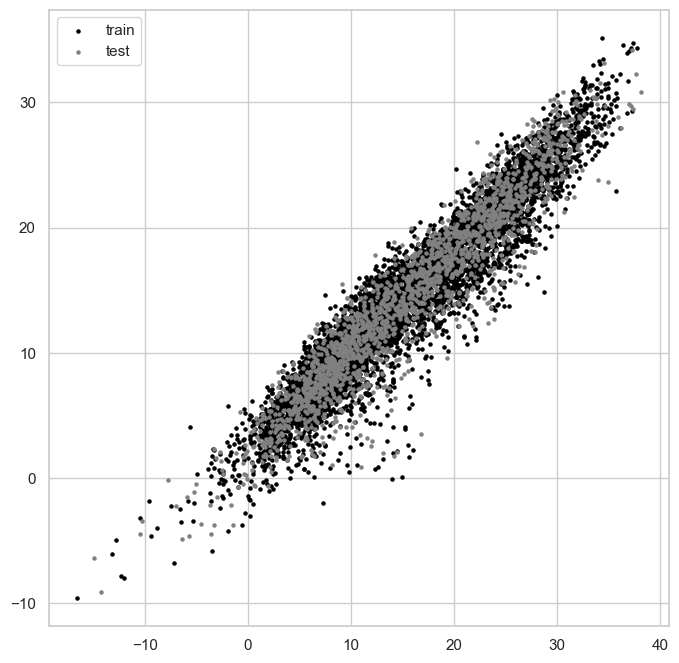

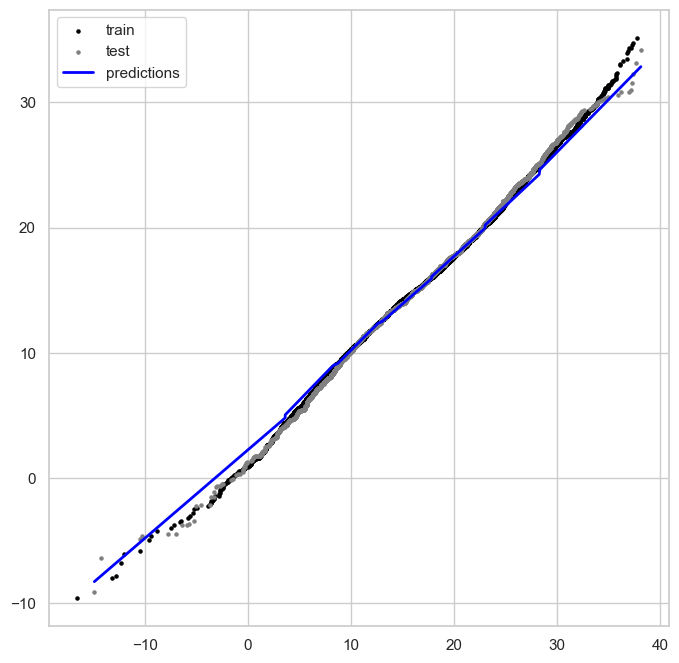

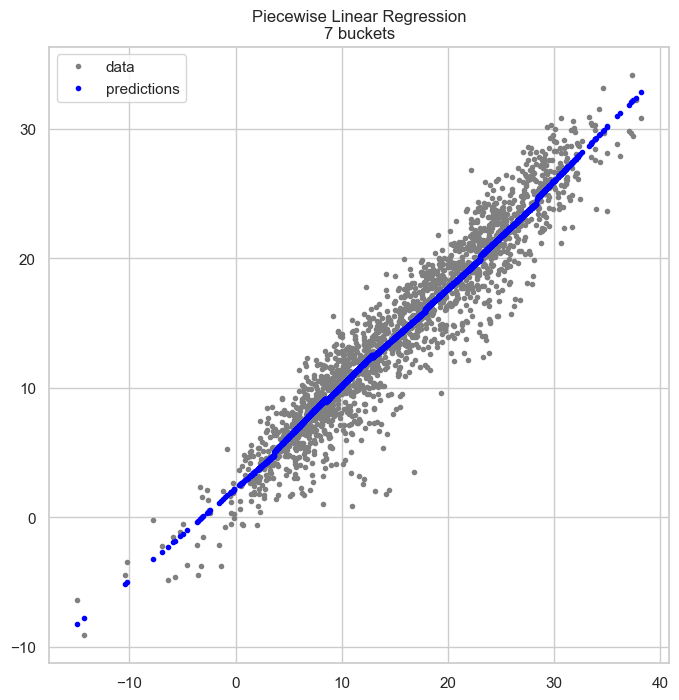

In [7]:
y_train = y_train[:, 0]
for strat in ['kmeans', 'uniform', 'quantile']:
    model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=strat))

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(strat, model.score(X_test, y_test))
    
model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
model.fit(X_train, y_train)
pred = model.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(X_train, y_train, c=c['train'], s=5, label='train')
plt.scatter(X_test, y_test, c=c['test'], s=5, label='test')
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(np.sort(X_train, axis=0), np.sort(y_train, axis=0), c=c['train'], s=5, label='train')
plt.scatter(np.sort(X_test, axis=0), np.sort(y_test, axis=0), c=c['test'], s=5, label='test')
plt.plot(np.sort(X_test, axis=0), np.sort(pred, axis=0), c=c['predict'], lw=2, label='predictions')
ax.legend()

# fig, ax = plt.subplots(1, 1)
# ax.plot(Xq_test[:, 0], yq_test, ".", label='data', c=c['test'])
# ax.plot(Xq_test[:, 0], predq, ".", label="predictions", c=c['predict'])
# ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
# ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(X_test[:, 0], y_test, ".", label='data', c=c['test'])
ax.plot(X_test[:, 0], pred, ".", label="predictions", c=c['predict'])
ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
ax.legend()

https://github.com/pangeo-data/scikit-downscale/blob/main/examples/bcsd_example.ipynb

In [8]:
# open a small dataset for training
training = xr.open_zarr("../data/downscale_test_data.zarr.zip", group="training")
training

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_23584\1628510199.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  training = xr.open_zarr("../data/downscale_test_data.zarr.zip", group="training")


<xarray.Dataset>
Dimensions:      (point: 5, time: 13483)
Coordinates:
    lat          (point) float32 ...
    lon          (point) float32 ...
  * time         (time) datetime64[ns] 1979-01-01T11:30:00 ... 2015-11-30T11:...
Dimensions without coordinates: point
Data variables: (12/15)
    DIV          (point, time) float32 ...
    PREC_ACC_C   (point, time) float32 ...
    PREC_ACC_NC  (point, time) float32 ...
    PREC_TOT     (point, time) float32 ...
    PSFC         (point, time) float32 ...
    QVAPOR       (point, time) float32 ...
    ...           ...
    T2min        (point, time) float32 ...
    T_MEAN       (point, time) float32 ...
    T_RANGE      (point, time) float32 ...
    U            (point, time) float32 ...
    V            (point, time) float32 ...
    W            (point, time) float32 ...
Attributes:
    NCO:                        "4.5.5"
    history:                    Wed Mar  1 13:48:35 2017: ncatted -a calendar...
    history_of_appended_files:  Wed Feb  8 14:15:52 2017: Appended file wrf_d...
    nco_openmp_thread_number:   1

In [9]:
# open a small dataset of observations (targets)
targets = xr.open_zarr("../data/downscale_test_data.zarr.zip", group="targets")
targets

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_23584\3505218138.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  targets = xr.open_zarr("../data/downscale_test_data.zarr.zip", group="targets")


<xarray.Dataset>
Dimensions:  (time: 23376, point: 5)
Coordinates:
    lat      (point) float64 ...
    lon      (point) float64 ...
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2013-12-31
Dimensions without coordinates: point
Data variables:
    Prec     (time, point) float32 ...
    Tmax     (time, point) float32 ...
    Tmin     (time, point) float32 ...
    wind     (time, point) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    CDO:                       Climate Data Operators version 1.6.4 (http://c...
    Conventions:               CF-1.4
    NCO:                       4.4.5
    history:                   Fri Oct 10 17:54:37 2014: cdo ifthenelse /Volu...
    nco_openmp_thread_number:  1

In [10]:
# extract 1 point of training data for precipitation and temperature
X_temp = training.isel(point=0).to_dataframe()[["T2max"]].resample("MS").mean() - 273.13
X_pcp = training.isel(point=0).to_dataframe()[["PREC_TOT"]].resample("MS").sum() * 24
display(X_temp.head(), X_pcp.head())

,T2max
time,
1979-01-01,3.174103
1979-02-01,5.273163
1979-03-01,13.126099
1979-04-01,13.500275
1979-05-01,20.057251


,PREC_TOT
time,
1979-01-01,102.553276
1979-02-01,216.159973
1979-03-01,98.423416
1979-04-01,129.309418
1979-05-01,41.323780


In [11]:
# extract 1 point of target data for precipitation and temperature
y_temp = targets.isel(point=0).to_dataframe()[["Tmax"]].resample("MS").mean()
y_pcp = targets.isel(point=0).to_dataframe()[["Prec"]].resample("MS").sum()
display(y_temp.head(), y_pcp.head())

,Tmax
time,
1950-01-01,-2.065484
1950-02-01,6.638215
1950-03-01,8.544193
1950-04-01,13.238667
1950-05-01,16.199354


,Prec
time,
1950-01-01,214.043198
1950-02-01,237.654190
1950-03-01,269.569855
1950-04-01,149.984604
1950-05-01,65.975349


C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: title={'center': '12'}>

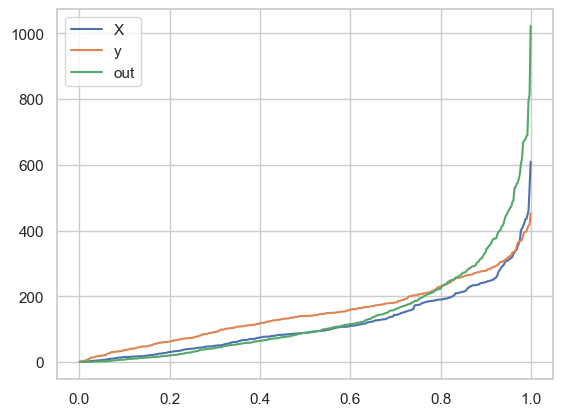

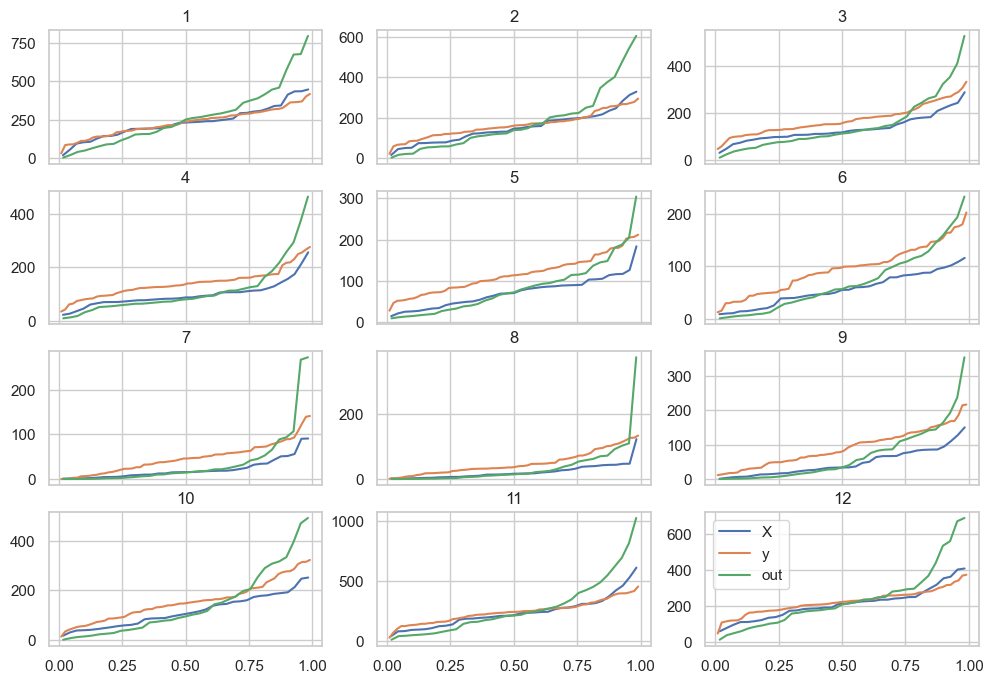

In [12]:
# Fit/predict the BCSD Precipitation model
from skdownscale.pointwise_models import BcsdPrecipitation
bcsd_pcp = BcsdPrecipitation()
bcsd_pcp.fit(X_pcp.loc['1979':'2013'], y_pcp.loc['1979':'2013'])
out = bcsd_pcp.predict(X_pcp.loc['1979':'2013']) * X_pcp.loc['1979':'2013']
plot_cdf(X=X_pcp.loc['1979':'2013'], y=y_pcp.loc['1979':'2013'], out=out)
plot_cdf_by_month(X=X_pcp, y=y_pcp, out=out)

C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: title={'center': '12'}>

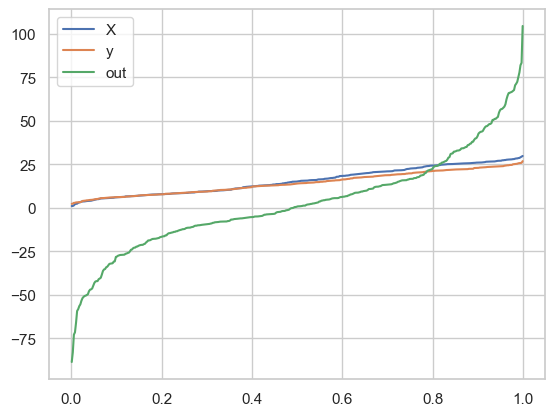

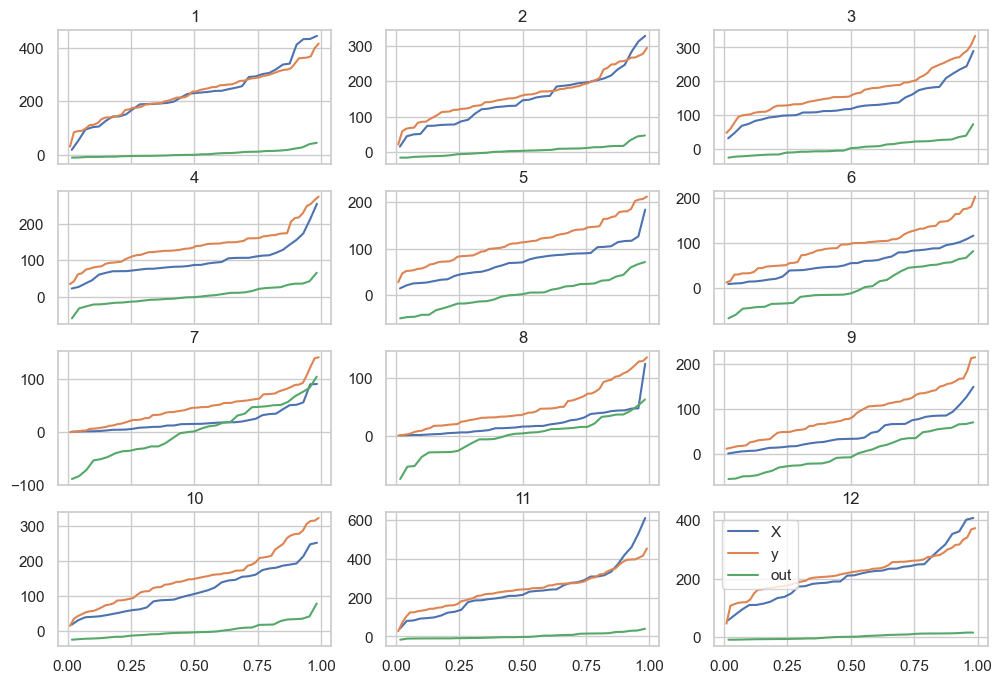

In [13]:
# Fit/predict the BCSD Precipitation model
from skdownscale.pointwise_models import BcsdTemperature
bcsd_temp = BcsdTemperature()
bcsd_temp.fit(X_temp.loc['1979':'2013'], y_temp.loc['1979':'2013'])
out = bcsd_temp.predict(X_temp.loc['1979':'2013']) * X_temp.loc['1979':'2013']
plot_cdf(X=X_temp.loc['1979':'2013'], y=y_temp.loc['1979':'2013'], out=out)
plot_cdf_by_month(X=X_pcp, y=y_pcp, out=out)

## 2.2 Models as cattle, not pets

https://github.com/earthcube2020/ec20_hamman_etal/blob/master/2020ECAHM-scikit-downscale.ipynb

In [14]:
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.preprocessing import KBinsDiscretizer

In [15]:
# load sample data
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
# extract 1 point of training data for precipitation and temperature
df = (
    data.isel(point=0)
    .to_dataframe()[['T2max', 'PREC_TOT']]
    .rename(columns={'T2max': 'tmax', 'PREC_TOT': 'pcp'})
)
df['tmax'] -= 273.13
df['pcp'] *= 24
training= df.resample('1d').first()
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='targets')
        # extract 1 point of training data for precipitation and temperature
targets =data.isel(point=0).to_dataframe()[['Tmax', 'Prec']].rename(columns={'Tmax': 'tmax', 'Prec': 'pcp'})


C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_23584\2347140478.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_23584\2347140478.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing st

In [16]:
def ARRM(n_bins=7):
    return Pipeline([
        ('')
    ])


sns.set(style='whitegrid')
c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

qqwargs = {'n_quantiles': 1e6, 'copy': True, 'subsample': 1e6}
n_bins = 7

In [17]:
X = training[['tmax']]['1980': '2000'].values
y = targets[['tmax']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
y_train = y_train[:, 0]
    
model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
#print(strat, model.score(X_test, y_test))
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation


models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0)
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')

In [20]:
# extract training / prediction data
X_train = training[['tmax']][train_slice]
y_train = targets[['tmax']][train_slice]
X_predict = training[['tmax']][predict_slice]

# Fit all models
for key, model in models.items():
    model.fit(X_train, y_train)

C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWar

In [21]:
# store predicted results in this dataframe
predict_df = pd.DataFrame(index = X_predict.index)

for key, model in models.items():
    print('key')
    print(key)
    print('model')
    print(model)
    print(model.predict(X_predict))
    if type(model.predict(X_predict))==pd.core.frame.DataFrame:
        if len(list(model.predict(X_predict).columns))>1:
            predict_df[key] = model.predict(X_predict)[['pred']].values # [['pred']] added to deal with piecewise regressor
        else:
            predict_df[key] = model.predict(X_predict)
    else:
        predict_df[key] = model.predict(X_predict) # [['pred']] added to deal with piecewise regressor

# show a table of the predicted data
display(predict_df.head())

key
GARD: PureAnalog-best-1
model
PureAnalog(n_analogs=1)
       pred  exceedance_prob  prediction_error
0      4.50              1.0               0.0
1      6.13              1.0               0.0
2      5.46              1.0               0.0
3      8.57              1.0               0.0
4      5.67              1.0               0.0
...     ...              ...               ...
3647  11.37              1.0               0.0
3648  14.55              1.0               0.0
3649  14.47              1.0               0.0
3650   9.11              1.0               0.0
3651   1.42              1.0               0.0

[3652 rows x 3 columns]
key
GARD: PureAnalog-sample-10
model
PureAnalog(kind='sample_analogs', n_analogs=10)
       pred  exceedance_prob  prediction_error
0      7.29              1.0          1.546624
1      3.55              1.0          2.199347
2      5.74              1.0          1.920702
3      9.16              1.0          1.424612
4     10.01              1.0     

,GARD: PureAnalog-best-1,GARD: PureAnalog-sample-10,GARD: PureAnalog-weight-10,GARD: PureAnalog-weight-100,GARD: PureAnalog-mean-10,GARD: AnalogRegression-100,GARD: LinearRegression,BCSD: BcsdTemperature,Sklearn: RandomForestRegressor
time,,,,,,,,,
1990-01-01,4.50,5.67,5.375299,5.697786,5.895,5.931445,5.781470,4.528703,5.2024
1990-01-02,6.13,0.32,3.543398,3.264698,2.561,2.515919,2.524320,-1.584750,4.6935
1990-01-03,5.46,9.00,4.963575,4.933534,4.692,4.862730,4.944165,2.848937,4.6736
1990-01-04,8.57,7.21,8.369125,8.239455,7.340,7.255379,7.107426,6.687825,8.4134
1990-01-05,5.67,8.80,7.424970,7.583703,7.705,7.711861,7.878298,8.296424,6.5789


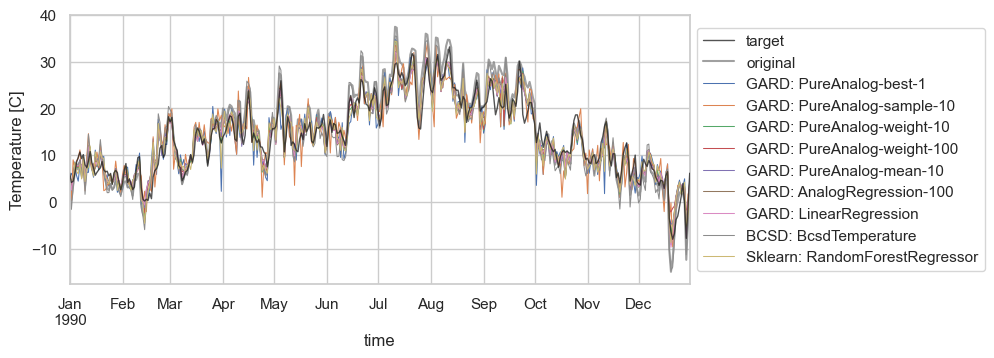

In [22]:
fig, ax = plt.subplots(figsize=(8, 3.5))
targets['tmax'][time_slice].plot(ax=ax, label='target', c='k', lw=1, alpha=0.75, legend=True, zorder=10)
X_predict['tmax'][time_slice].plot(label='original', c='grey', ax=ax, alpha=0.75, legend=True)
predict_df[time_slice].plot(ax=ax, lw=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_ylabel('Temperature [C]')

In [23]:
# calculate r2
score = (predict_df.corrwith(targets.tmax[predict_slice]) **2).sort_values().to_frame('r2_score')
display(score)

,r2_score
GARD: PureAnalog-sample-10,0.818836
GARD: PureAnalog-best-1,0.820361
BCSD: BcsdTemperature,0.858260
Sklearn: RandomForestRegressor,0.864160
GARD: PureAnalog-weight-10,0.881284
GARD: PureAnalog-weight-100,0.892049
GARD: PureAnalog-mean-10,0.899293
GARD: AnalogRegression-100,0.906216
GARD: LinearRegression,0.906316


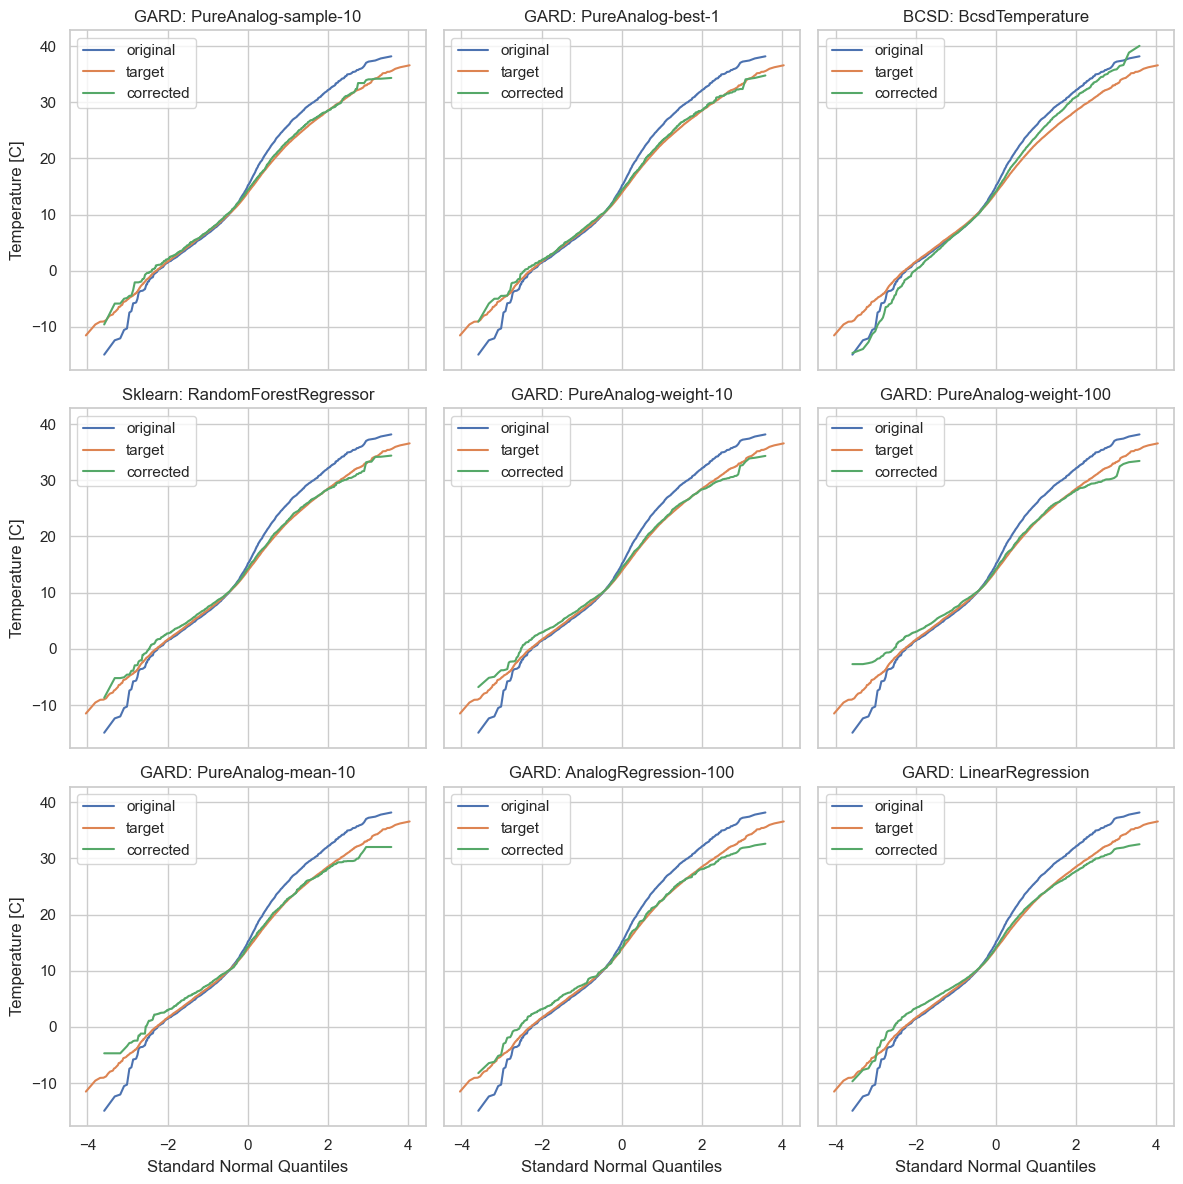

In [24]:
from utils import prob_plots

fig = prob_plots(X_predict, targets['tmax'], predict_df[score.index.values], shape=(3, 3), figsize=(12, 12))


## Zscore

Z-Score bias correction is a good technique for target variables with Gaussian probability distributions, such as zonal wind speed.

In [25]:
from skdownscale.pointwise_models import ZScoreRegressor

In [26]:
# load sample data
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
# extract 1 point of training data for precipitation and temperature
df = (
    data.isel(point=0)
    .to_dataframe()[['T2max', 'PREC_TOT']]
    .rename(columns={'T2max': 'tmax', 'PREC_TOT': 'pcp'})
)
df['tmax'] -= 273.13
df['pcp'] *= 24
training= df.resample('1d').first()
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='targets')
        # extract 1 point of training data for precipitation and temperature
targets =data.isel(point=0).to_dataframe()[['Tmax', 'Prec']].rename(columns={'Tmax': 'tmax', 'Prec': 'pcp'})


C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_23584\2347140478.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_23584\2347140478.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing st

In [27]:
Trainings = training[['tmax']][train_slice]
target = targets[['tmax']][train_slice]
future = training[['tmax']][predict_slice]

In [28]:

# open a small dataset
training = get_sample_data('wind-hist')
target = get_sample_data('wind-obs')
future = get_sample_data('wind-rcp')

FileNotFoundError: [Errno 2] No such file or directory: b'C:\\Users\\CLMRX\\OneDrive - COWI\\Documents\\GitHub\\data\\uas\\uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.Colorado.19801990.nc'

In [ ]:
# bias correction using ZScoreRegresssor
zscore = ZScoreRegressor()
zscore.fit(Trainings, target)
fit_stats = zscore.fit_stats_dict_
out = zscore.predict(future)
predict_stats = zscore.predict_stats_dict_

In [ ]:
# visualize the datasets
from utils import zscore_ds_plot

zscore_ds_plot(training, target, future, out)

In [ ]:
from utils import zscore_correction_plot

zscore_correction_plot(zscore)

## Automatic parallelization

In [ ]:
# parameters
train_slice = slice('1980', '1982')  # train time range
holdout_slice = slice('1990', '1991')  # prediction time range

# bounding box of downscaling region
lon_slice = slice(-124.8, -120.0) 
lat_slice = slice(50, 45)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [ ]:
from dask.distributed import Client

client = Client()
client

In [ ]:
import xarray as xr

fnames = [f'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_{year}.nc'
          for year in range(int(train_slice.start), int(train_slice.stop) + 1)]
# open the data and cleanup a bit of metadata
obs = xr.open_mfdataset(fnames, engine='pydap',combine='nested', concat_dim='day').rename({'day': 'time'}).drop('crs')

obs_subset = obs['air_temperature'].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
display(obs_subset)
obs_subset.isel(time=0).plot()

# Add models to list to test

In [29]:
from mlinsights.mlmodel import QuantileLinearRegression
from mlinsights.mlmodel import PiecewiseRegressor
from mlinsights.mlmodel import QuantileMLPRegressor
from sklearn.preprocessing import KBinsDiscretizer

In [30]:
# load sample data
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
# extract 1 point of training data for precipitation and temperature
df = (
    data.isel(point=0)
    .to_dataframe()[['T2max', 'PREC_TOT']]
    .rename(columns={'T2max': 'tmax', 'PREC_TOT': 'pcp'})
)
df['tmax'] -= 273.13
df['pcp'] *= 24
training= df.resample('1d').first()
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='targets')
        # extract 1 point of training data for precipitation and temperature
targets =data.isel(point=0).to_dataframe()[['Tmax', 'Prec']].rename(columns={'Tmax': 'tmax', 'Prec': 'pcp'})


C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_23584\2347140478.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_23584\2347140478.py:12: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing st

In [31]:
def ARRM(n_bins=7):
    return Pipeline([
        ('')
    ])


sns.set(style='whitegrid')
c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

qqwargs = {'n_quantiles': 1e6, 'copy': True, 'subsample': 1e6}
n_bins = 7

In [32]:
X = training[['tmax']]['1980': '2000'].values
y = targets[['tmax']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation


models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0),
    'Sklearn: QuantileMLPRegressor': QuantileMLPRegressor(),
    'Sklearn: QuantileLinearRegression': QuantileLinearRegression(),
    #'Sklearn: PiecewiseRegressor': PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
    
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')

In [34]:
# extract training / prediction data
X_train = training[['tmax']][train_slice]
y_train = targets[['tmax']][train_slice]
X_predict = training[['tmax']][predict_slice]

# Fit all models
for key, model in models.items():
    print(model)
    if 'PiecewiseRegressor' in key: # does't work
        model.fit(X_train.values.reshape((len(X_train),1)), y_train.values.reshape((len(y_train),)))
    if 'QuantileLinearRegression' in key:
        model.fit(X_train.values.reshape((len(X_train.values),1)), y_train.values.reshape((len(y_train.values),)))
    else:
        model.fit(X_train, y_train)

PureAnalog(n_analogs=1)
PureAnalog(kind='sample_analogs', n_analogs=10)
PureAnalog(kind='weight_analogs', n_analogs=10)
PureAnalog(kind='weight_analogs', n_analogs=100)
PureAnalog(kind='mean_analogs', n_analogs=10)
AnalogRegression(n_analogs=100)
LinearRegression()
BcsdTemperature(return_anoms=False)
RandomForestRegressor(random_state=0)


C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWar

QuantileMLPRegressor()


C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\mlinsights\mlmodel\quantile_mlpregressor.py:371: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


QuantileLinearRegression()


C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\linear_model\_base.py:148: Fu

In [35]:
# store predicted results in this dataframe
predict_df = pd.DataFrame(index = X_predict.index)

for key, model in models.items():
    print('key')
    print(key)
    print('model')
    print(model)
    if 'PiecewiseRegressor' in key: # does't work
        predict_df[key] = model.predict(X_predict)
    if type(model.predict(X_predict))==pd.core.frame.DataFrame:
        if len(list(model.predict(X_predict).columns))>1:
            predict_df[key] = model.predict(X_predict)[['pred']].values # [['pred']] added to deal with piecewise regressor
        else:
            predict_df[key] = model.predict(X_predict)
    else:
        predict_df[key] = model.predict(X_predict) # [['pred']] added to deal with piecewise regressor

# show a table of the predicted data
display(predict_df.head())

key
GARD: PureAnalog-best-1
model
PureAnalog(n_analogs=1)
key
GARD: PureAnalog-sample-10
model
PureAnalog(kind='sample_analogs', n_analogs=10)
key
GARD: PureAnalog-weight-10
model
PureAnalog(kind='weight_analogs', n_analogs=10)
key
GARD: PureAnalog-weight-100
model
PureAnalog(kind='weight_analogs', n_analogs=100)
key
GARD: PureAnalog-mean-10
model
PureAnalog(kind='mean_analogs', n_analogs=10)
key
GARD: AnalogRegression-100
model
AnalogRegression(n_analogs=100)
key
GARD: LinearRegression
model
LinearRegression()
key
BCSD: BcsdTemperature
model
BcsdTemperature(return_anoms=False)
key
Sklearn: RandomForestRegressor
model
RandomForestRegressor(random_state=0)
key
Sklearn: QuantileMLPRegressor
model
QuantileMLPRegressor()
key
Sklearn: QuantileLinearRegression
model
QuantileLinearRegression()


C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but QuantileMLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but QuantileMLPRegressor was fitted without feature names
  warnings.warn(
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but QuantileLinearRegression was fitted without feature names
  warnings.warn(
C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but QuantileLinearRegression was fitted without feature names
  warnings.warn(


,GARD: PureAnalog-best-1,GARD: PureAnalog-sample-10,GARD: PureAnalog-weight-10,GARD: PureAnalog-weight-100,GARD: PureAnalog-mean-10,GARD: AnalogRegression-100,GARD: LinearRegression,BCSD: BcsdTemperature,Sklearn: RandomForestRegressor,Sklearn: QuantileMLPRegressor,Sklearn: QuantileLinearRegression
time,,,,,,,,,,,
1990-01-01,4.50,6.93,5.375299,5.697786,5.895,5.931445,5.781470,4.528703,5.2024,5.959606,5.919342
1990-01-02,6.13,3.41,3.543398,3.264698,2.561,2.515919,2.524320,-1.584750,4.6935,2.631544,2.655350
1990-01-03,5.46,5.46,4.963575,4.933534,4.692,4.862730,4.944165,2.848937,4.6736,5.100852,5.080278
1990-01-04,8.57,5.74,8.369125,8.239455,7.340,7.255379,7.107426,6.687825,8.4134,7.310643,7.248082
1990-01-05,5.67,7.03,7.424970,7.583703,7.705,7.711861,7.878298,8.296424,6.5789,8.081644,8.020574


In [36]:
X_predict.values.reshape((len(X_predict.values),))

array([ 4.526367 ,  0.4281006,  3.4728394, ..., 10.409576 ,  4.3778076,
        3.7963867], dtype=float32)

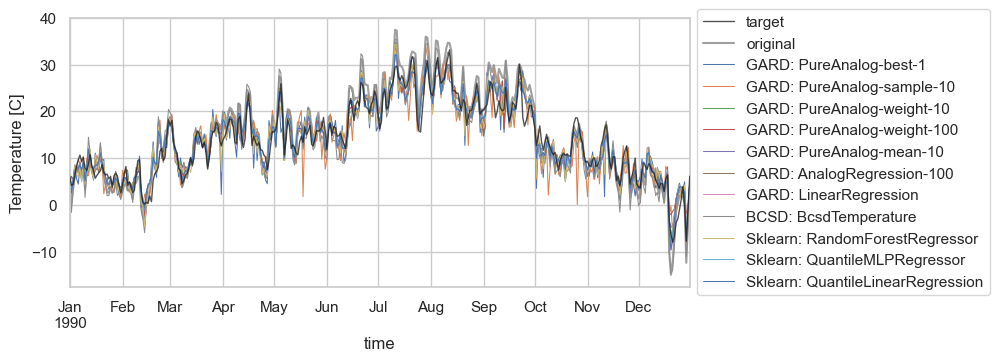

In [37]:
fig, ax = plt.subplots(figsize=(8, 3.5))
targets['tmax'][time_slice].plot(ax=ax, label='target', c='k', lw=1, alpha=0.75, legend=True, zorder=10)
X_predict['tmax'][time_slice].plot(label='original', c='grey', ax=ax, alpha=0.75, legend=True)
predict_df[time_slice].plot(ax=ax, lw=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_ylabel('Temperature [C]')

In [38]:
# calculate r2
score = (predict_df.corrwith(targets.tmax[predict_slice]) **2).sort_values().to_frame('r2_score')
display(score)

,r2_score
GARD: PureAnalog-best-1,0.820361
GARD: PureAnalog-sample-10,0.820928
BCSD: BcsdTemperature,0.858260
Sklearn: RandomForestRegressor,0.864160
GARD: PureAnalog-weight-10,0.881284
GARD: PureAnalog-weight-100,0.892049
GARD: PureAnalog-mean-10,0.899293
GARD: AnalogRegression-100,0.906216
GARD: LinearRegression,0.906316
Sklearn: QuantileLinearRegression,0.906316


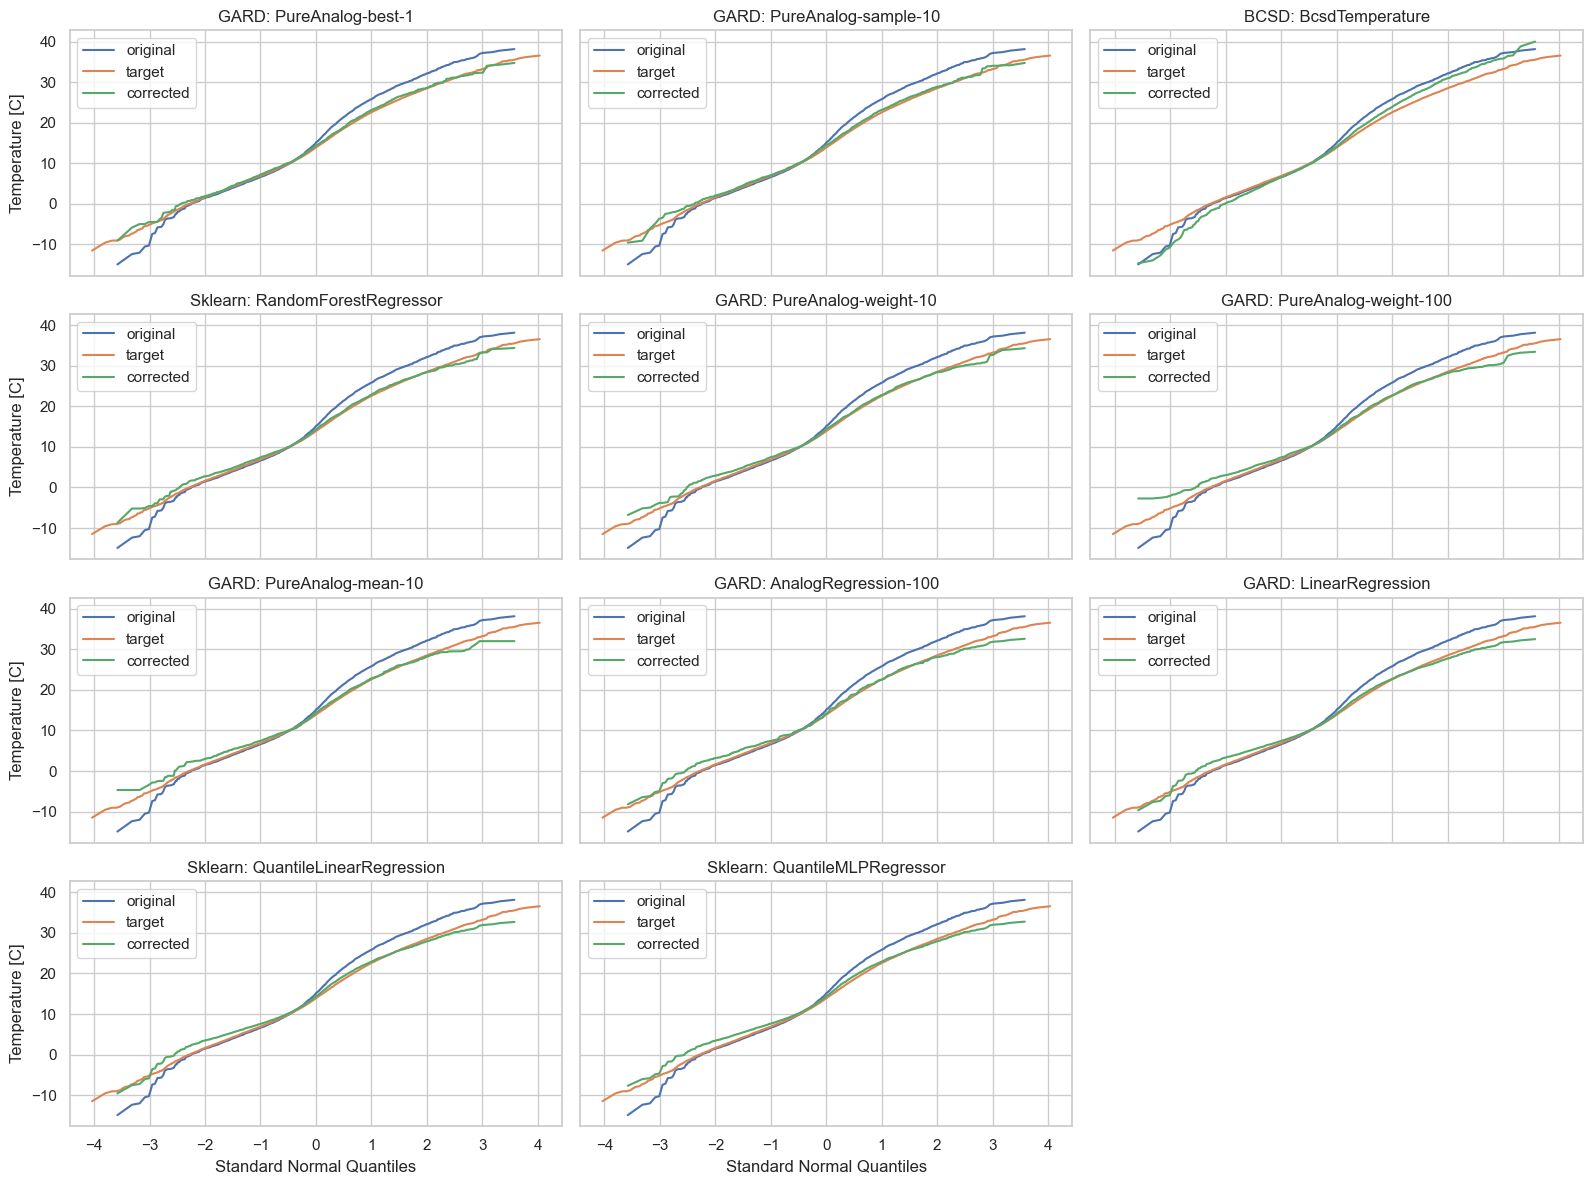

In [39]:
from utils import prob_plots

fig = prob_plots(X_predict, targets['tmax'], predict_df[score.index.values], shape=(4, 3), figsize=(16, 12))
